# Lecture 4) Regularisation for Neural Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

#import theano 
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import InputLayer,Dense, Activation
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils import to_categorical  
from keras.utils import plot_model



In [2]:
# updatable plot

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

### 4.1) Weight Decay

Neural networks are typically heavily over-parameterized. This very often leads to neural networks being prone to 'overfitting.'  

One way to counteract this is early stopping (which works not only for neural networks).

An alternative that also reduces over-parameterization is weight decay.
This introduces a weighted penalty term to the loss:

The weighting parameter is 

$\lambda$ in $E(w)=E(w_0)+\lambda \sum \frac{1}{2}w^2$


In Keras, this can be implemented using 'Layer Weight Regularizers.'
For the penalty term on the loss function, the L1 norm and L2 norm are available (covered in the lecture on the L2 norm).

Regularization applies to individual layers and is specified as an option when configuring the corresponding layer:

    dense = tf.keras.layers.Dense(3, kernel_regularizer='l2')
    
We’ll test this using an example: the classification of heart attacks..."

In [3]:
Heart = pd.read_csv("../Data/Heart.csv")
#len(Heart)
#Heart.head()

Heart_y=Heart['AHD']
Heart_X=np.array(Heart[['Age','Sex','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope']])


Heart_y=np.array(Heart_y.replace(['No', 'Yes'], [0,1]))
#Heart_y



X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(Heart_X, Heart_y, test_size=0.3, shuffle=True)

scaler = StandardScaler()
X_train_H = scaler.fit_transform(X_train_H)
X_test_H = scaler.transform(X_test_H)

In [4]:
y_train_H_bin = to_categorical(y_train_H,num_classes = 2)
y_test_H_bin = to_categorical(y_test_H,num_classes = 2)
#print(y_train_bin);

Now, let's run the model for classification without any regularizations and examine the distribution of the weights after training:

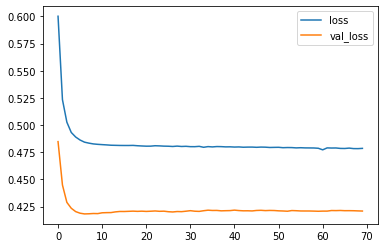

In [5]:
#EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights=True)

NNClassModel=Sequential()

NNClassModel.add(InputLayer(input_shape=(10,)))
NNClassModel.add(Dense(500,activation='tanh',use_bias=True))
NNClassModel.add(Dense(2,activation='softmax',use_bias=True))

sgd = SGD(learning_rate=0.005)
NNClassModel.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

NNClassModHistory=NNClassModel.fit(X_train_H, y_train_H_bin,
          shuffle=True,
          epochs=70,
          batch_size=1,
          verbose=0,
          validation_data=(X_test_H, y_test_H_bin),                  
          callbacks=[plot_losses])

In [6]:
losslNN,acclNN=NNClassModel.evaluate(X_test_H, y_test_H_bin);
acclNN

3/3 [==============================] - 0s 3ms/step - loss: 0.4209 - accuracy: 0.8022


0.8021978139877319

The model is now fully trained.
Retrieving the weights after 70 epochs:

In [7]:
hidden1=NNClassModel.layers[0]
weights, biases = hidden1.get_weights()

#weights

np.mean(np.ndarray.flatten(weights))

0.0004925142

Representation of the weights (between the input and dense layer) as a histogram.

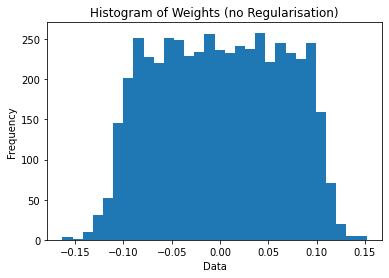

In [8]:
plt.hist(np.ndarray.flatten(weights), density=False, bins=30)  # density=False would make probabilities
plt.ylabel('Frequency')
plt.xlabel('Data');
plt.title('Histogram of Weights (no Regularisation)');

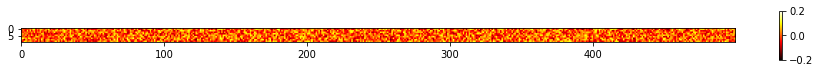

In [9]:
fig1=plt.figure(figsize=(16,9))
fig1=plt.imshow(weights, cmap='hot', vmin=-0.2, vmax=0.2)
plt.colorbar(fig1, shrink=0.1);


Now we apply a square weight decay to the hidden layer (all settings as before):

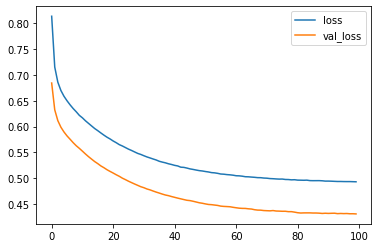

In [10]:
l2=tf.keras.regularizers.L2(l2=0.01) # Lambda = 0.01

NNClassModelWD=Sequential()

NNClassModelWD.add(InputLayer(input_shape=(10,)))
NNClassModelWD.add(Dense(500,activation='tanh',use_bias=True,kernel_regularizer='l2'))
NNClassModelWD.add(Dense(2,activation='softmax',use_bias=True))

sgd = SGD(learning_rate=0.005)
NNClassModelWD.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

NNClassModHistoryWD=NNClassModelWD.fit(X_train_H, y_train_H_bin,
          shuffle=True,
          epochs=100,
          batch_size=1,
          verbose=0,
          validation_data=(X_test_H, y_test_H_bin),                  
          callbacks=[plot_losses])

In [11]:
losslNNWD,acclNNWD=NNClassModelWD.evaluate(X_test_H, y_test_H_bin);
acclNNWD

3/3 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.7912


0.791208803653717

Already in the learning curve, it is clear that the effect of overfitting has been significantly reduced.

If everything went well, many of the weights should now have been shifted toward 0.  
We will again retrieve the weight matrix and plot the histogram:

In [12]:
hiddenWD=NNClassModelWD.layers[0]
weightsWD, biasesWD = hiddenWD.get_weights()

#weightsWD
np.mean(np.ndarray.flatten(weightsWD))

0.00033357047

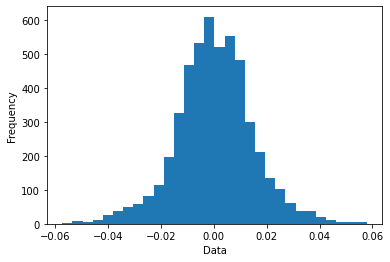

In [13]:
plt.hist(np.ndarray.flatten(weightsWD), density=False, bins=30)  # density=True would make probabilities
plt.ylabel('Frequency')
plt.xlabel('Data');

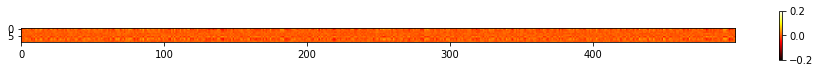

In [14]:
fig2=plt.figure(figsize=(16,9))
fig2=plt.imshow(weightsWD, vmin=-0.2, vmax=0.2,cmap='hot')
plt.colorbar(fig2, shrink=0.1);

### Exercise 1)

The network with L2 weight decay does not yet seem to have reached the minimum test error.  

- How many epochs can the model be trained without the test error increasing again?
- What does the weight matrix look like at that point?
- What influence does the parameter 

$\lambda$ in $E(w)=E(w_0)+\lambda \sum \frac{1}{2}w^2$

have on the result?

Keras also allows for weight decay using the L1 norm.  

- What result does this second penalty form yield?
- How long does this model train until it reaches the optimal test error?
- What do the weights look like at that point?


### 9.2) Ensembles with Keras

We have seen that the error of an ensemble model is smaller than the error of individual models.
That’s a great result...  

So let’s try using an ensemble of classification networks.  
In the simplest case, the structure and training are the same for all networks in the ensemble.  
The models differ only in their initialization.

First, we define a function to train models with a specific structure.
The network is a simple classifier with 50 neurons in the hidden layer.

In [15]:
# fit model on dataset
def fit_model(X_train_H, y_train_H_bin):
    # define model
    model = Sequential()
    model.add(InputLayer(input_shape=(10,)))
    model.add(Dense(50,activation='tanh',input_shape=(10,)))
    model.add(Dense(2,activation='softmax'))

    sgd = SGD(learning_rate=0.1)
    model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

    model.fit(X_train_H, y_train_H_bin,
          shuffle=True,
          epochs=100,
          batch_size=10,
          verbose=0)
    return model

In [16]:
# create directory for models
#from os import makedirs
#makedirs('models')

Now, we train a number of models (here, n_members=5) using our training data and save the models in the folder "models" under the names model_1 to model_5

In [17]:
# fit and save models
n_members = 5
for i in range(n_members):
    # fit model
    model = fit_model(X_train_H, y_train_H_bin)
    # save model
    filename = 'models/model_' + str(i + 1) + '.keras'
    model.save(filename)
    print('>Saved %s' % filename)

>Saved models/model_1.keras
>Saved models/model_2.keras
>Saved models/model_3.keras
>Saved models/model_4.keras
>Saved models/model_5.keras


here is a function that allows you to load the models again:

In [18]:
# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/model_' + str(i + 1) + '.keras'
        # load model from file
        model = keras.models.load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

...now we load our models again:

In [19]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.keras
>loaded models/model_2.keras
>loaded models/model_3.keras
>loaded models/model_4.keras
>loaded models/model_5.keras
Loaded 5 models


The models can now be evaluated individually or used for predictions:

In [20]:
# evaluate standalone models on test dataset
for model in members:

    lossEns,accEns = model.evaluate(X_test_H, y_test_H_bin)
    print('Model Accuracy: %.3f' % accEns)

3/3 [==============================] - 0s 2ms/step - loss: 0.4361 - accuracy: 0.8132
Model Accuracy: 0.813
3/3 [==============================] - 0s 2ms/step - loss: 0.4455 - accuracy: 0.8022
Model Accuracy: 0.802
3/3 [==============================] - 0s 3ms/step - loss: 0.4615 - accuracy: 0.8022
Model Accuracy: 0.802
3/3 [==============================] - 0s 3ms/step - loss: 0.4591 - accuracy: 0.8242
Model Accuracy: 0.824
3/3 [==============================] - 0s 3ms/step - loss: 0.4336 - accuracy: 0.8132
Model Accuracy: 0.813


In [21]:
# predict with standalone models on test dataset
all_y_hat = list()
all_y_hat_score=list()

for model in members:

    y_hat = model.predict(X_test_H)
    y_hat_score=np.round(y_hat) #score for class =1 else 0
    all_y_hat.append(y_hat)
    all_y_hat_score.append(y_hat_score)
    

3/3 [==============================] - 0s 2ms/step


In [22]:
np.shape(all_y_hat)

#all_y_hat[3]

(5, 91, 2)

The score can be calculated for each model individually from the predictions:

In [23]:
test_accuracyEns = accuracy_score(all_y_hat_score[0],y_test_H_bin)*100
test_accuracyEns

81.31868131868131

### Exercise 2)

For an ensemble forecast, you need to somehow calculate the majority decision (in the case of regression, the mean is used).  

- Calculate an ensemble forecast from the majority decision.
- How does the ensemble model perform?

In [24]:
np.shape(all_y_hat_score)

(5, 91, 2)

In [25]:
np.shape(y_test_H_bin)

(91, 2)